## Text similarity experiment

Requires results from ```scripts/stability.py```

Produces Figure 3

In [1]:
import pandas as pd
import Levenshtein as lv
import numpy as np
import os

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,amsfonts,geometry}'
mpl.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams.update({
    'font.family':'serif',
    "font.serif": ["Computer Modern Roman"],
    "text.usetex": True,
    "font.size": 45,
    "figure.figsize":(13,8),
    "lines.markersize": 20
})
plt.rcParams['axes.autolimit_mode'] = 'round_numbers'
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0

Functions to calculate the edit distance

In [3]:
def prefix(row):
    prefix=[]
    for j in range(len(row['interventions'])):
        prefix.append(len("".join([row['token_list'][x] for x in row['token_list'] if int(x)<row['interventions'][j]])))
    return prefix

def edit_distance_lv(row, intervention=None):
    if intervention or intervention==0:
        # Condition on a single intervention
        n_interventions=1
    else:
        n_interventions = len(row['interventions'])
    edit_distance_cf = np.zeros(n_interventions)
    edit_distance_prior = np.zeros(n_interventions)
    fact = row['factual_response']

    for j in range(n_interventions):
        if intervention or intervention==0:
            cf = row['cf_response'][min(intervention,len(row['interventions']) - 1 )]
            prior = row['prior_response'][min(intervention,len(row['interventions']) - 1)]
            prefix = row['prefix'][min(intervention, len(row['interventions']) - 1)]
        else:
            cf = row['cf_response'][j]
            prior = row['prior_response'][j]
            prefix = row['prefix'][j]
        try:
            edit_distance_cf[j] = lv.distance(fact,cf) / max(len(fact[prefix:]), len(cf[prefix:]))
            edit_distance_prior[j] = lv.distance(fact,prior) / max(len(fact[prefix:]), len(prior[prefix:]))
        except(ZeroDivisionError):
            edit_distance_cf[j]=0
            edit_distance_prior[j]=0
    return edit_distance_cf, edit_distance_prior


Read input

In [19]:
input_file="../outputs/stability/stability_strings"

df=pd.read_parquet(f"{input_file}.parquet", engine='fastparquet')
df_orig=df.copy()

Prepare results to plot

In [5]:
def edit_distance_vs_param(df,param='temperature'):
    if param=='temperature':
        df=df[df['sampler_type'].isin(['vocabulary'])]
        var_to_plot='temperature'
    elif param=='p':
        df=df[df['temperature'].isin([0.6])]
        df=df[df['sampler_type'].isin(['top-p token','vocabulary'])]
        df['sampler_param']=df['sampler_param'].replace([0],[1])
        var_to_plot='sampler_param'
    elif param=='k':
        df=df[df['temperature'].isin([0.6])]
        df=df[df['sampler_type'].isin(['top-k token','vocabulary'])]
        df['sampler_param']=df['sampler_param'].replace([0],[128256])
        var_to_plot='sampler_param'

    ints = df['interventions'].apply(lambda x: len(x))
    df=df.copy()
    df['prefix']=df.apply(prefix,axis=1)
    df=df.reset_index()

    df[['Counterfactual Token Generation','Interventional Token Generation']] = df.apply(edit_distance_lv, axis=1, result_type='expand')

    results = df[['Counterfactual Token Generation','Interventional Token Generation',var_to_plot]].explode(['Counterfactual Token Generation','Interventional Token Generation'])
        

    res_to_plot = results.melt(id_vars=[var_to_plot], 
                                value_vars=['Counterfactual Token Generation','Interventional Token Generation'],
                                var_name='method',
                                value_name='edit_distance')
    return results

In [6]:
results_temperature=edit_distance_vs_param(df_orig.copy(),'temperature')
results_p=edit_distance_vs_param(df_orig.copy(),'p')
results_k=edit_distance_vs_param(df_orig.copy(),'k')

Plots

In [12]:
def plot_edit_distance_vs_param(results,param='temperature'):
    if param=='temperature':
        var_to_plot='temperature'
        xlabel=r'$\tau$'
        xticks=[0,0.2,0.4,0.6,0.8,1]
        xticklabels=['0.0','0.2','0.4','0.6','0.8','1.0']
        xlims=[-0.05,1.05]
        file_name='tau_vs_ed'
    elif param=='p':
        var_to_plot='sampler_param'
        xlabel=r'$p$'
        xticks=[0.75,0.8,0.85,0.9,0.95,1]
        xticklabels=['0.75','0.80','0.85','0.90','0.95','1.00']
        xlims=[0.74,1.01]
        file_name='p_vs_ed'
    elif param=='k':
        var_to_plot='sampler_param'
        xlabel=r'$k$'
        xticks=[1,10,100,1000,10000,100000]
        xticklabels=[r'$1$',r'$10$',r'$10^2$',r'$10^3$',r'$10^4$',r'$10^5$']
        xlims=[0.9,160000]
        file_name='k_vs_ed'

    res_to_plot = results.melt(id_vars=[var_to_plot], 
                                value_vars=['Counterfactual Token Generation','Interventional Token Generation'],
                                var_name='method',
                                value_name='edit_distance')
    
    fig,ax=plt.subplots()

    cols=sns.color_palette("husl", 6)
    palette=[cols[3],cols[5]]

    sns.lineplot(data=res_to_plot,ax=ax, y='edit_distance', hue='method',palette=palette, style='method',markers=['o','^'],dashes=False,markeredgecolor=None, x=var_to_plot,estimator='mean')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Edit Distance')
    ax.get_legend().remove()
    ax.spines[['right', 'top']].set_visible(False)
    if param=='k':
        ax.set_xscale('log')
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_xlim(xlims[0],xlims[1])
    ax.set_yticks([0.45,0.50,0.55,0.60,0.65,0.70])
    ax.set_yticklabels(['0.45','0.50','0.55','0.60','0.65','0.70'])
    ax.set_ylim(0.44,0.7)

    plt.savefig(f'../figures/edit_distance/{file_name}.pdf',bbox_inches='tight')

def plot_legend():
    cols=sns.color_palette("husl", 6)
    fig,ax1=plt.subplots()
    ax1.plot([0,1],[0,1],color=cols[5],marker='^',label='Interventional Token Generation')
    ax1.plot([0,1],[0,1],color=cols[3],marker='o',label='Counterfactual Token Generation')
    plt.close()
    fig,ax=plt.subplots(figsize=(36,1))
    ax.legend(*ax1.get_legend_handles_labels(),ncol=2,frameon=False, loc='center')
    ax.spines[['right', 'top','left','bottom']].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.savefig('../figures/edit_distance/legend.pdf',bbox_inches='tight')

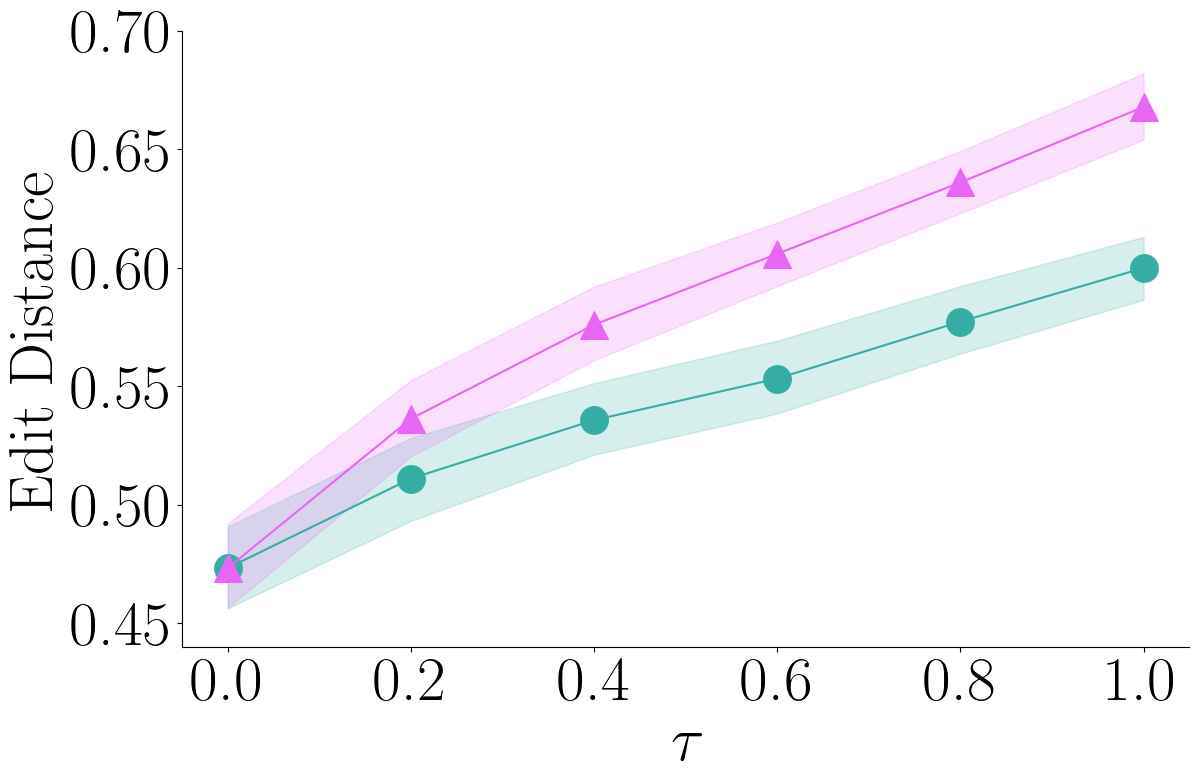

In [8]:
plot_edit_distance_vs_param(results_temperature,param='temperature')

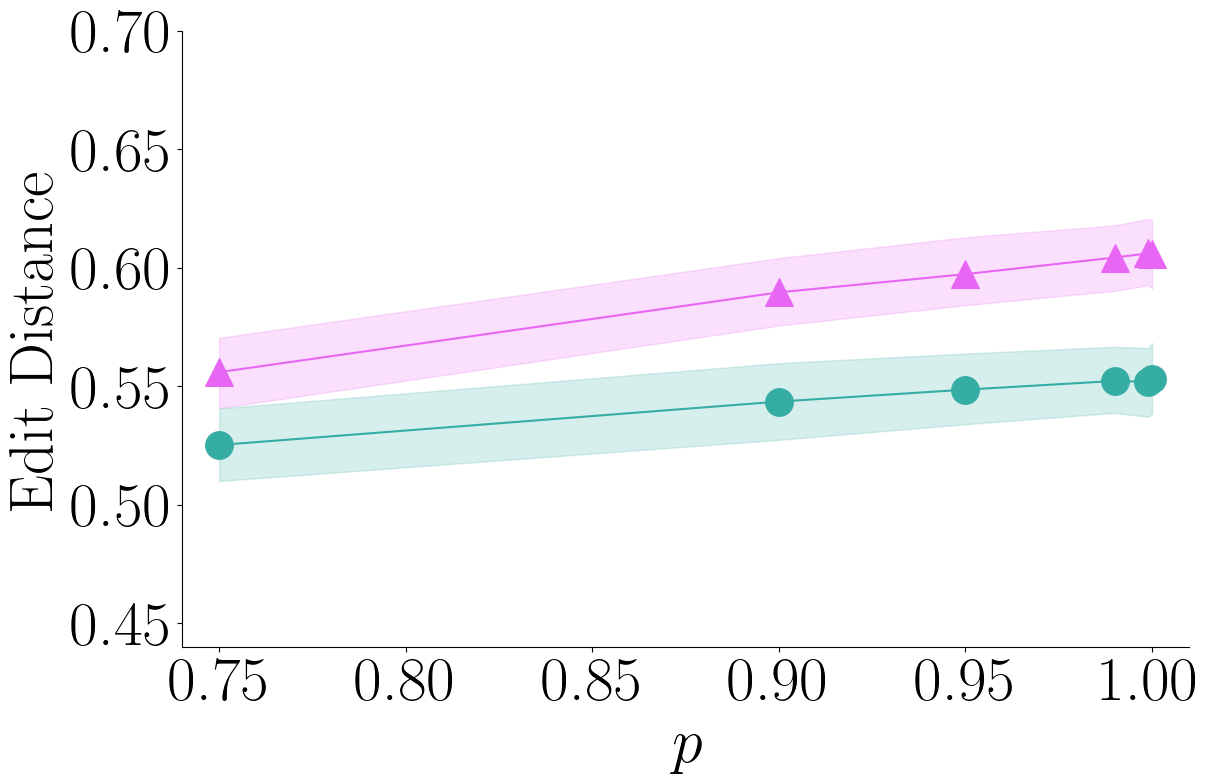

In [15]:
plot_edit_distance_vs_param(results_p,param='p')

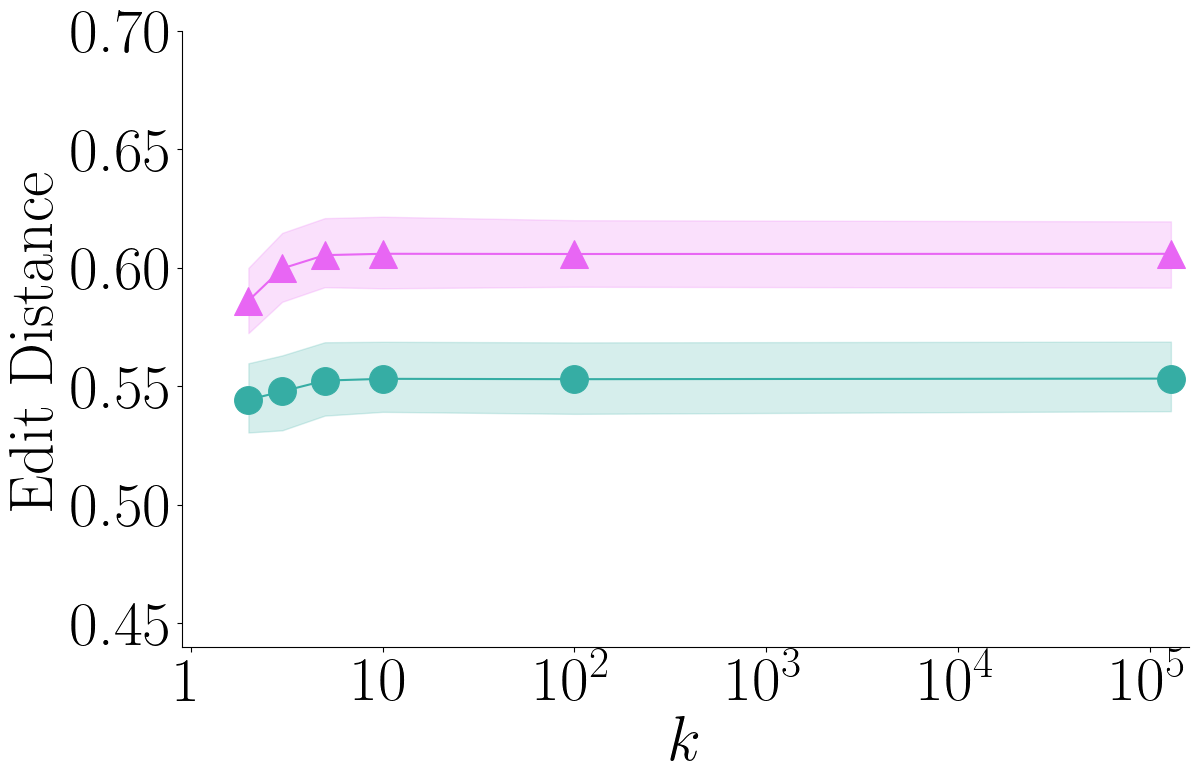

In [14]:
plot_edit_distance_vs_param(results_k,param='k')

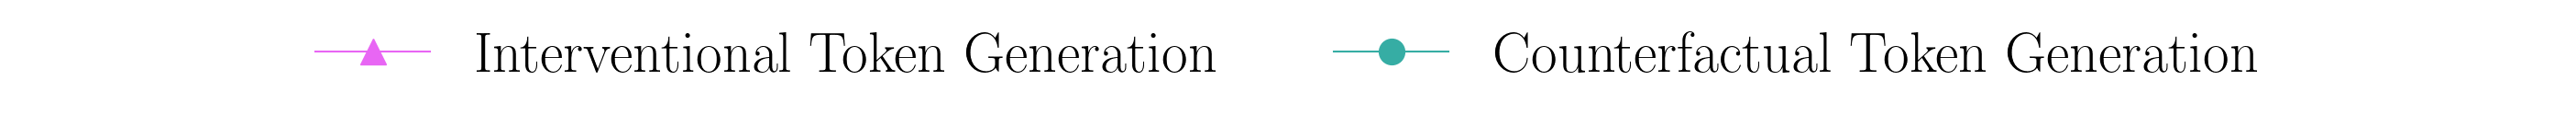

In [11]:
plot_legend()